In [116]:
import getpass
import os
import random
import re
import tarfile
import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import pandas as pd

### Split dataset
Use 80% of data to train and 20% to validate. 

In [11]:
'''
# Set the paths
base_folder = 'Classification'
train_folder = os.path.join(base_folder, 'train')
val_folder = os.path.join(base_folder, 'val')

# List of class folders (excluding 'OOD', 'train', 'val')
class_folders = [
    '0.1CHF', '0.1EUR', '0.01EUR', '0.2CHF', '0.2EUR', '0.02EUR', 
    '0.5CHF', '0.05CHF', '0.5EUR', '0.05EUR', '1CHF', '1EUR', 
    '2CHF', '2EUR', '5CHF', 'OOD'
]

for class_folder in class_folders:
    # Full paths to the class folders
    source_folder = os.path.join(base_folder, class_folder)
    train_class_folder = os.path.join(train_folder, class_folder)
    val_class_folder = os.path.join(val_folder, class_folder)
    
    # Ensure the train and val folders for each class exist
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(val_class_folder, exist_ok=True)
    
    # Get a list of all .JPG files in the source folder
    files = [f for f in os.listdir(source_folder) if f.lower().endswith('.jpg')]
    
    # Shuffle the files
    random.shuffle(files)
    
    # Calculate the split point
    split_point = int(len(files) * 0.8)
    
    # Split the files
    train_files = files[:split_point]
    val_files = files[split_point:]
    
    # Move the files to the respective train and val folders
    for file in train_files:
        shutil.move(os.path.join(source_folder, file), os.path.join(train_class_folder, file))
    
    for file in val_files:
        shutil.move(os.path.join(source_folder, file), os.path.join(val_class_folder, file))
    
    print(f"Moved {len(train_files)} files to {train_class_folder}")
    print(f"Moved {len(val_files)} files to {val_class_folder}")
    if not os.listdir(source_folder):
        os.rmdir(source_folder)
        print(f"Deleted empty folder: {source_folder}")

print("Data has successfully been split")
'''


'\n# Set the paths\nbase_folder = \'Classification\'\ntrain_folder = os.path.join(base_folder, \'train\')\nval_folder = os.path.join(base_folder, \'val\')\n\n# List of class folders (excluding \'OOD\', \'train\', \'val\')\nclass_folders = [\n    \'0.1CHF\', \'0.1EUR\', \'0.01EUR\', \'0.2CHF\', \'0.2EUR\', \'0.02EUR\', \n    \'0.5CHF\', \'0.05CHF\', \'0.5EUR\', \'0.05EUR\', \'1CHF\', \'1EUR\', \n    \'2CHF\', \'2EUR\', \'5CHF\'\n]\n\nfor class_folder in class_folders:\n    # Full paths to the class folders\n    source_folder = os.path.join(base_folder, class_folder)\n    train_class_folder = os.path.join(train_folder, class_folder)\n    val_class_folder = os.path.join(val_folder, class_folder)\n    \n    # Ensure the train and val folders for each class exist\n    os.makedirs(train_class_folder, exist_ok=True)\n    os.makedirs(val_class_folder, exist_ok=True)\n    \n    # Get a list of all .JPG files in the source folder\n    files = [f for f in os.listdir(source_folder) if f.lower().en

Note: when defining the classes, the labels must be in the same order as the folders in images!

In [117]:
# Define the paths for train and validation directories
train_dir =  'Classification/train'
valid_dir = 'Classification/val'

#name of the classes
classes = ("0.1CHF", "0.1EUR", "0.01EUR", "0.2CHF", "0.2EUR", "0.2EUR", "0.5CHF", "0.05CHF", "0.5EUR", "0.05EUR", "1CHF", "1EUR", "2CHF", "2EUR", "5CHF", "OOD")
NUM_CLASSES = len(classes) 
assert(NUM_CLASSES==16)
# batch size
batch_size = 10

## ImageFolder
ImageFolder uses directory structure to determine the class labels.
So we will have the following structure: (manually classified)

```text
images/
|-- train/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....jpg
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ....JPG
|
|-- val/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
```
Note: some coins are more dicy to classify, i.e. the tale CHF coins which are very similar, we thus need to measure the diameter of the coins. Luckily all our images have the same dimensions.
Note also that two images were removed from the train folder (hands with hairs on them)

## Preprocessing and ensuring mapping is correct

In [118]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(valid_dir, transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)



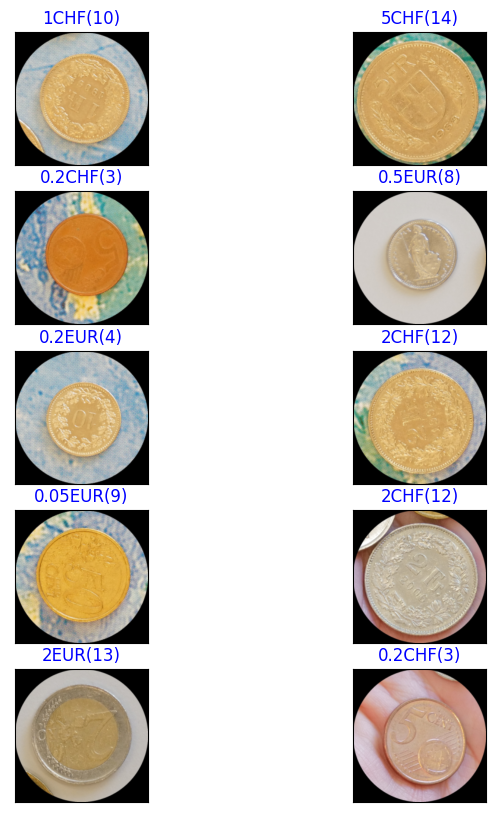

In [119]:
# Visualization of images
def plot_images_from_dataset(images, labels):
    batch_size = images.shape[0]
    fig = plt.figure(figsize=(8, 10))
    for idx in np.arange(int(batch_size)):
        ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # revert normalisation
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                    color=("blue"))

dataiter = iter(train_loader) 
images, labels = next(dataiter) 

plot_images_from_dataset(images, labels)

As we see the mapping is off => make our own custome mapping, same order as directory folders!

Visualize if mapping is correct

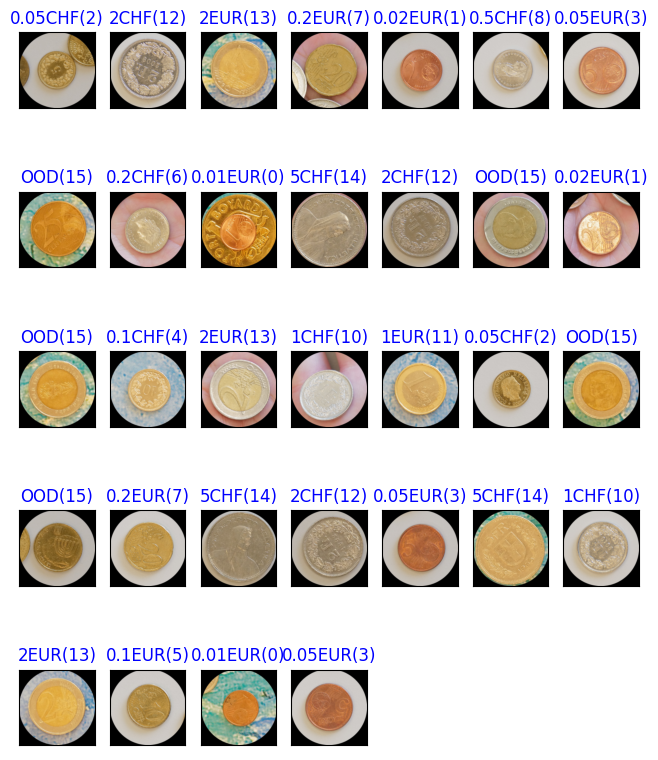

In [120]:
# Define custom mapping
custom_mapping = {
    '0.1CHF': 0,
    '0.1EUR': 1,
    '0.01EUR': 2,
    '0.2CHF': 3,
    '0.2EUR': 4,
    '0.02EUR': 5,
    '0.5CHF': 6,
    '0.05CHF': 7,
    '0.5EUR': 8,
    '0.05EUR': 9,
    '1CHF': 10,
    '1EUR': 11,
    '2CHF': 12,
    '2EUR': 13,
    '5CHF': 14,
    'OOD': 15
}


# Create dataset with custom mapping
train_set = datasets.ImageFolder(train_dir, transform=transform)
valid_set = datasets.ImageFolder(valid_dir, transform=transform)

# Override the class_to_idx mapping with the custom mapping
train_set.class_to_idx = custom_mapping
valid_set.class_to_idx = custom_mapping

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

# Define a function to plot images from the dataset
def plot_images_from_dataset(images, labels, classes):
    batch_size = images.shape[0]
    rows = 5
    cols = (batch_size + rows - 1) // rows  # Calculate the number of columns 
    fig = plt.figure(figsize=(8, 2 * rows))  # Adjust figure size based on rows
    for idx in range(batch_size):
        ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # Revert normalization
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]], str(labels[idx].item())), color=("blue"))

# Get a batch of images and labels from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the images
plot_images_from_dataset(images, labels, train_set.classes)

## Visualize class distribution

how many images in the train set:  299


No handles with labels found to put in legend.


images per class in dataloader:  {'2CHF': 17, '0.5CHF': 9, '0.05EUR': 26, '0.05CHF': 23, '0.5EUR': 15, '5CHF': 22, '0.1EUR': 18, '2EUR': 25, 'OOD': 37, '0.2CHF': 24, '1EUR': 8, '1CHF': 16, '0.2EUR': 33, '0.01EUR': 12, '0.1CHF': 14}


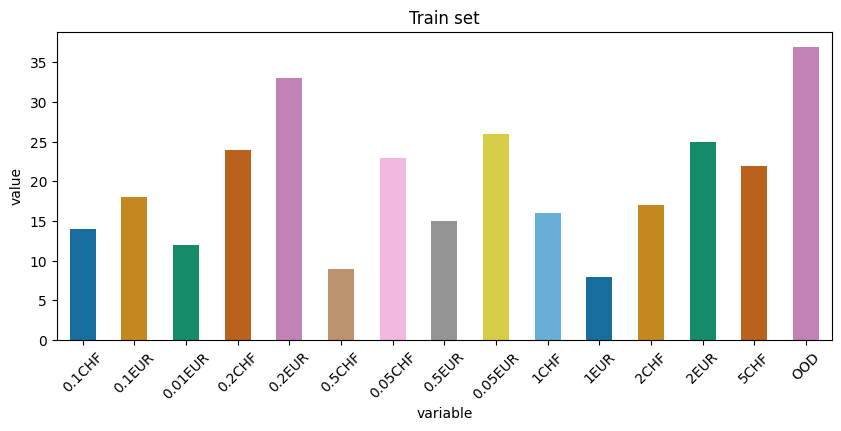

In [121]:
# class distribution
import seaborn as sns
from collections import Counter

print("how many images in the train set: ", len(train_set.targets))


def plot_class_distribution_for_dataloader(dataloader):
# count how many images are outputted by dataloader per class
    count_dict = {}
    for _, target in dataloader:
        for t in target:
            t = classes[int(t)]
            if t not in count_dict:
                count_dict[t] = 0
            count_dict[t] += 1
    print("images per class in dataloader: ", count_dict)
    plt.figure(figsize=(10, 4))
    #plot the class ditribution
    sns.barplot(data=pd.DataFrame.from_dict([count_dict])[list(classes)].melt(),
                  x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)

    plt.title("Train set")
    plt.xticks(rotation=45)
    plt.legend().set_visible(False)
    plt.show()

plot_class_distribution_for_dataloader(train_loader)
## the training set is perfectly balanced: same number of image for all classes

In the plot above we visualize the class distribution.

## Define metrics: accuracy and f1score

In [122]:
from sklearn.metrics import f1_score, accuracy_score
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

## Define Model

In [123]:
import torchvision.models as models

In [124]:
class CoinNet(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        # Loading AlexNet
        self.model = models.alexnet(pretrained=True)
        # Changing the last layers
        # to reduce the computational complexity we reduce the size of hidden layers
        self.model.classifier[1] = nn.Linear(9216, 64)
        self.model.classifier[4] = nn.Linear(64, 32)
        self.model.classifier[6] = nn.Linear(32, 16)

    def freeze_feature_layers(self):
        # Freeze the feature extraction part
        for param in self.model.features:
            param.requires_grad_(False)

    def forward(self, x):
        return self.model(x)

In [125]:
##
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output



def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''
    model.train()
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        #clean previously computed gradients
        optimizer.zero_grad()

        # forward
        outputs = model(data)

        #compute predictions
        with torch.no_grad():
            _, preds = torch.max(outputs, 1)

        #compute loss
        loss = criterion(outputs, target)

        #do backward and oprimizer steps
        loss.backward()
        optimizer.step()

        # compute metrics
        # no gradients should be propagated at this step
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)


        # log loss statistics
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [126]:
def evaluate(model, criterion, metrics, test_loader, device):
    model.eval()

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad(): # we don't compute gradients 
            data = x_batch.to(device)
            target = y_batch.to(device)

            #forward
            outputs = model(data)

            #compute loss
            loss = criterion(outputs, target)

            #compute predictions
            _, preds = torch.max(outputs, 1)

            # compute metrics
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)

            # log loss statistics
            epoch_loss += loss.item()

    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [127]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()



In [128]:
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


# Train NN without any data augmentation

# =====WE GOT 80.79% ACCURACY=============

train Loss: 0.8574,  ACC: 0.7099, F1-weighted: 0.5901
eval Loss: 0.8936,  ACC: 0.8079, F1-weighted: 0.6334


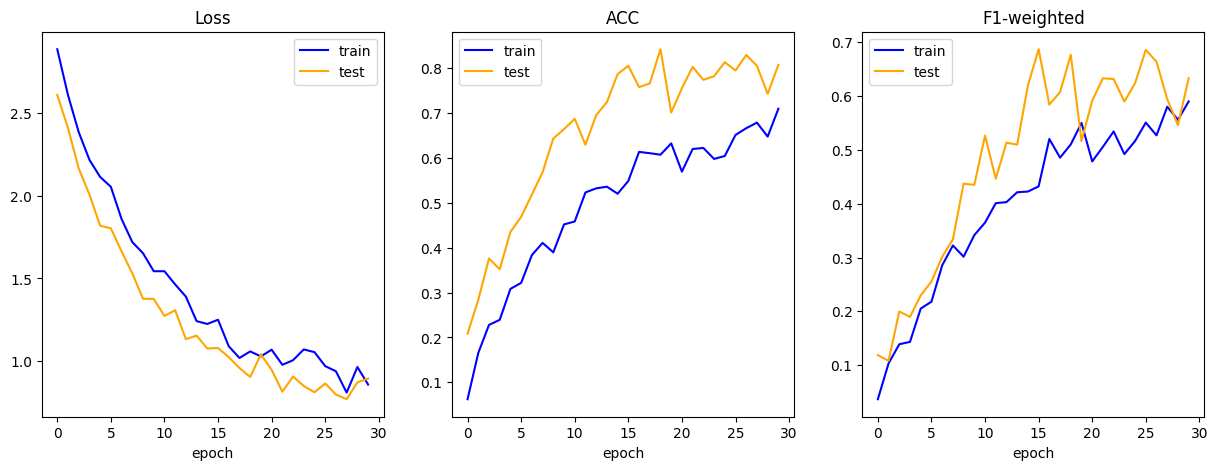

In [130]:
torch.manual_seed(42)

model = CoinNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')


## ---------- Generate predictions on test MARCHE PAS----------

In [134]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms

# Define the transformations for preprocessing the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to load the model
def load_model(model_path):
    model = CoinNet(weights="IMAGENET1K_V1")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to make predictions on images
def predict(model, image_folder):
    predictions = {}

    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        image_id = os.path.splitext(image_file)[0]
        image = Image.open(image_path).convert("RGB")
        image = image_transforms(image).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predictions[image_id] = predicted.item()

    return predictions

# Load the trained model
model_path = 'models_weights/base_model.pth'
model = load_model(model_path)

# Make predictions on images
test_folder = 'Classification/test'
predictions = predict(model, test_folder)

# Load sample submission CSV file
sample_submission_path = 'data/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# Fill sample submission with predictions
new_rows = []
for image_id, prediction in predictions.items():
    # Duplicate an existing row
    new_row = sample_submission.iloc[0].copy()
    # Modify the duplicated row with new predictions
    new_row['id'] = image_id
    new_row[str(prediction) + 'CHF'] = 1
    new_rows.append(new_row)

# Append the new rows to the sample submission
sample_submission = pd.concat([sample_submission] + new_rows, ignore_index=True)

# Fill NaN values with 0
sample_submission.fillna(0, inplace=True)

# Save filled sample submission to CSV
sample_submission.to_csv('predictions.csv', index=False)


# ========================================

## Feature augmentation
We try: RGB, not good since the validation data has the same colors as the train \\
Scaling / croping: not a good idea since once again the coins have a fixed size and are whole
Below we visualize the effect of the transforms applied.

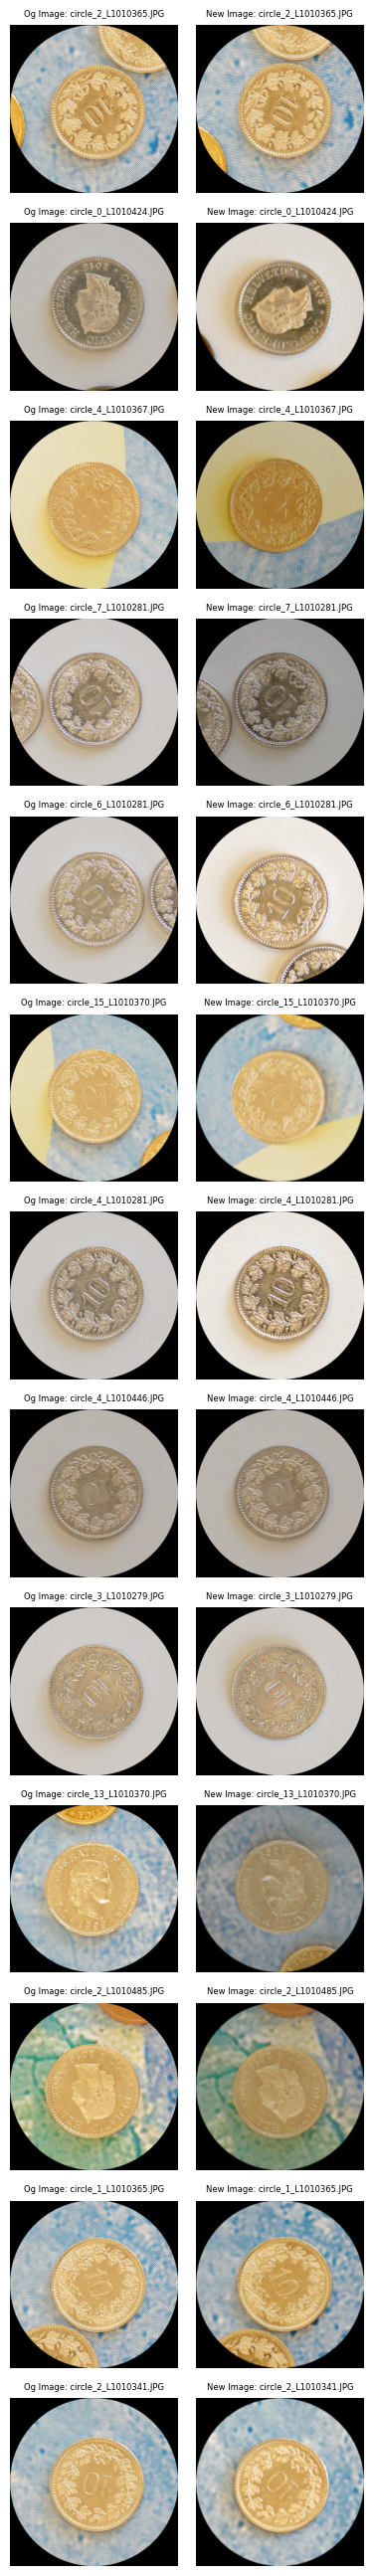

In [135]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import os

# Define the transformations
random_rotation = transforms.RandomRotation(degrees=(0, 360))
color_jitter = transforms.ColorJitter(brightness=(0.7,1), saturation=(0.5, 1))
gaussian_blur = transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=2)))
contrast_enhancement = transforms.Lambda(lambda img: ImageEnhance.Contrast(img).enhance(1.5))

# Compose transformations with random application
transform = transforms.Compose([
    transforms.RandomApply([random_rotation], p=1),
    transforms.RandomApply([color_jitter], p=0.5),
    transforms.RandomApply([gaussian_blur], p=0.3),
    transforms.RandomApply([contrast_enhancement], p=0.4),
    transforms.ToTensor(),  
])

image_folder = 'Classification/train/0.1CHF'
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]

def apply_transformations(image_path):
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image)
    transformed_image_pil = transforms.ToPILImage()(transformed_image)
    return image, transformed_image_pil

fig, axs = plt.subplots(len(image_files), 2, figsize=(4, 2 * len(image_files)))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    original_image, augmented_image = apply_transformations(image_path)

    # Original image
    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title(f'Og Image: {image_file}', fontsize=6)
    axs[i, 0].axis('off')

    # New transformed image
    axs[i, 1].imshow(augmented_image)
    axs[i, 1].set_title(f'New Image: {image_file}', fontsize=6)
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Now that we've visualized that the transformations make sense for our task, we create the following structure:
```text
images/
|-- train/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....jpg
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ....JPG
|
|-- val/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|-- augmented_train/
|   |-- 0.1CHF/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
|   |-- 0.1EUR/
|   |   |-- ....JPG
|   |   |-- ....JPG
|   |   |-- ...
```
Here augmented_train contains augmented images from the original training data. The augmented_train folder contains **only** the new images. We then merge the two to train.

In [136]:
train_dir = 'Classification/train'  
augmented_train_dir = 'Classification/augmented_train100' 
num_images_per_class = 100  

# Create augmented_train directory if it doesn't exist
if not os.path.exists(augmented_train_dir):
    os.makedirs(augmented_train_dir)

# Iterate over each class folder in the original training directory
for class_folder in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_folder)
    if not os.path.isdir(class_dir):  # Skip non-directory files like .DS_Store
        continue
    
    augmented_class_dir = os.path.join(augmented_train_dir, class_folder)
    
    # Create the augmented class directory if it doesn't exist
    if not os.path.exists(augmented_class_dir):
        os.makedirs(augmented_class_dir)
    
    # List original images in the class folder
    original_images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
    num_original_images = len(original_images)
    
    # Calculate the number of augmented images needed
    num_augmented_images_needed = max(0, num_images_per_class - num_original_images)
    
    # Generate augmented images and save them to the augmented class directory
    for i in range(num_augmented_images_needed):
        # Select an original image to augment (loop over original images if needed)
        original_image_name = original_images[i % num_original_images]
        original_image_path = os.path.join(class_dir, original_image_name)
        
        # Generate an augmented image
        original_image = Image.open(original_image_path)
        augmented_image = transform(original_image)
        
        # Convert the augmented image back to PIL format
        augmented_image_pil = transforms.ToPILImage()(augmented_image)
        
        # Save the augmented image
        augmented_image_path = os.path.join(augmented_class_dir, f'augmented_{i}_{original_image_name}')
        augmented_image_pil.save(augmented_image_path)


Let's check the correct number of classes is created and the total amount of pictures per class is the desired one (num_images_per_class):

In [139]:
for class_folder in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_folder)
    if not os.path.isdir(class_train_dir):  # Skip non-directory files like .DS_Store
        continue
    
    class_augmented_train_dir = os.path.join(augmented_train_dir, class_folder)
    
    # Count the number of images in train directory
    num_train_images = len([name for name in os.listdir(class_train_dir) if name.lower().endswith('.jpg')])
    
    # Count the number of images in augmented_train directory
    num_augmented_train_images = len([name for name in os.listdir(class_augmented_train_dir) if name.lower().endswith('.jpg')])
    
    # Assert that the sum of images in train and augmented_train directories is equal to num_images_per_class
    assert (num_train_images + num_augmented_train_images) == num_images_per_class, f"Sum of images in train and augmented_train for class {class_folder} should be equal to {num_images_per_class}."


We can now visualize the classes repartition again:

/var/folders/dp/qn00pnhj3l9d23jrvh68mcg00000gn/T/ipykernel_1836/55049195.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=color_palette)


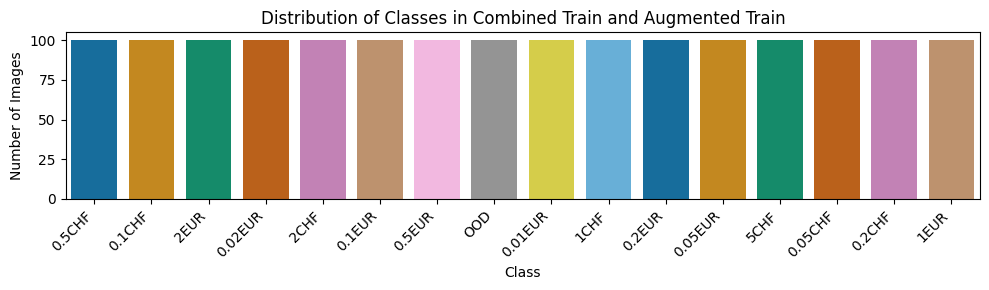

In [140]:
# Initialize a dictionary to store the count of images per class
class_counts = {}

# Count the number of images in each class in the train directory
for class_folder in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_folder)
    if not os.path.isdir(class_train_dir):  # Skip non-directory files like .DS_Store
        continue
    
    num_train_images = len([name for name in os.listdir(class_train_dir) if name.lower().endswith('.jpg')])
    class_counts[class_folder] = num_train_images

# Count the number of images in each class in the augmented_train directory
for class_folder in os.listdir(augmented_train_dir):
    class_augmented_train_dir = os.path.join(augmented_train_dir, class_folder)
    if not os.path.isdir(class_augmented_train_dir):  # Skip non-directory files like .DS_Store
        continue
    
    num_augmented_train_images = len([name for name in os.listdir(class_augmented_train_dir) if name.lower().endswith('.jpg')])
    class_counts[class_folder] = class_counts.get(class_folder, 0) + num_augmented_train_images

# Define color palette
color_palette = sns.color_palette("colorblind", len(class_counts))

# Plot the distribution of classes with the same colors as in the provided code snippet
plt.figure(figsize=(10, 3))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=color_palette)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Combined Train and Augmented Train')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


We can now train on combined original and augmented data.

In [141]:
from torch.utils.data import ConcatDataset, DataLoader
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder(train_dir, transform=transform)
augmented_train_dataset = ImageFolder(augmented_train_dir, transform=transform)
combined_dataset = ConcatDataset([train_dataset, augmented_train_dataset])
combined_train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)



train Loss: 2.2658,  ACC: 0.2606, F1-weighted: 0.2197
eval Loss: 0.8936,  ACC: 0.8079, F1-weighted: 0.6334


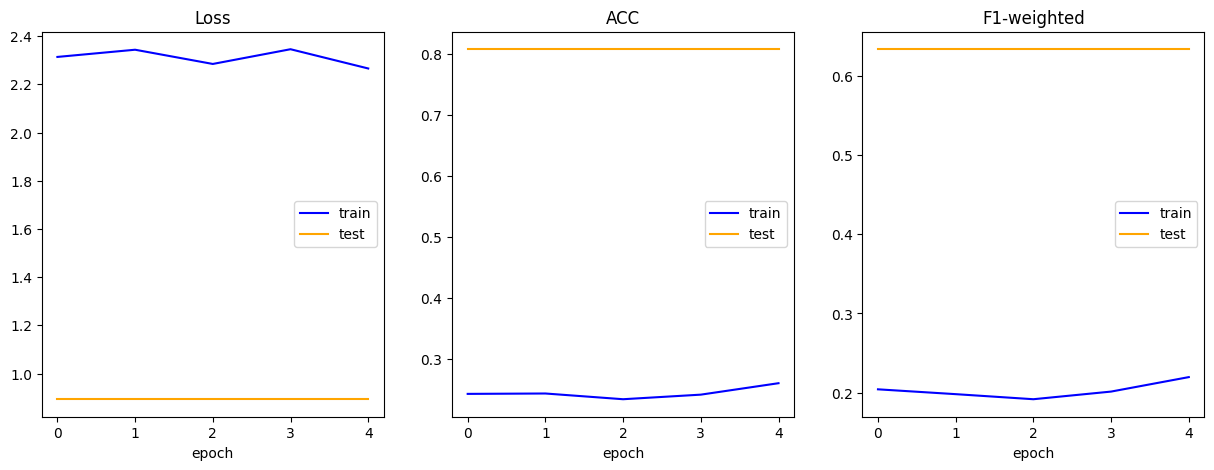

In [142]:
torch.manual_seed(42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])

train_dataset = ImageFolder(train_dir, transform=transform)
augmented_train_dataset = ImageFolder(augmented_train_dir, transform=transform)

combined_dataset = ConcatDataset([train_dataset, augmented_train_dataset])
batch_size = 32
combined_train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

N_EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, combined_train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# Save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'model_trained_on_combined_data.pth')


In [143]:
# Calculate the total number of images in the augmented training set
total_images = len(combined_dataset)

print("Total number of images after feature augmentation:", total_images)



Total number of images after feature augmentation: 1600


We see there's a lot of overfitting with the chosen transformations and number of images per class.

## Generate predictions on test set